## Cast Vote Record

Cast vote record stores, for every election district, the number of total ballots of each order, this is the most granular voting information. Available in https://vote.nyc/page/election-results-summary. (Note that if you're trying to reproduce this after 2025, you might need https://vote.nyc/page/election-results-summary-2025).

I download and unzip into `data/2025_Primary_CVR_2025-07-17`

I also need the shape files of the election districts available here: https://www.nyc.gov/content/planning/pages/resources/datasets/election-districts
I also unzipped this into `data/nyed_25c` (Make sure you get the ones from 2025).


In [1]:
import pandas as pd
import os
from tqdm import tqdm
import warnings
import geopandas as gpd
from io import BytesIO
import folium
from PIL import Image
from IPython.display import display

pd.set_option("display.max_rows", 500)

# suppress this noisy warning from openpyxl.
warnings.filterwarnings(
    "ignore",
    message="Workbook contains no default style, apply openpyxl's default",
    category=UserWarning,
)

In [2]:
# Load in the raw data.
cvr_subdirs = [subdir for subdir in os.listdir("../data") if "CVR" in subdir]
assert len(cvr_subdirs) == 1, "Multiple (or none of the) subdirs in data/ have 'CVR' in their name"
data_dir = os.path.join("../data", cvr_subdirs[0])

results_fns = [
    os.path.join(data_dir, filename)
    for filename in os.listdir(data_dir)
    if not "CandidacyID_To_Name" in filename
]
cand_id_to_name_fn = [
    os.path.join(data_dir, filename)
    for filename in os.listdir(data_dir)
    if "CandidacyID_To_Name" in filename
]
assert (
    len(cand_id_to_name_fn) == 1
), f"Multiple files in {data_dir} have 'CandidacyID_To_Name' in the name"
cand_id_to_name_fn = cand_id_to_name_fn[0]
cand_id_to_name = (
    pd.read_excel(cand_id_to_name_fn)
    .astype(str)
    .set_index("CandidacyID")
    .DefaultBallotName.to_dict()
)

# shape files for the election districts
shape_file_dir = [subdir for subdir in os.listdir("../data") if subdir.startswith("nyed")]
assert len(shape_file_dir) == 1, "Multiple (or none of the) subdirs in data/ start with 'nyed'"
gdf = gpd.read_file(os.path.join("../data", shape_file_dir[0], "nyed.shp"))

In [88]:
# load each xlsx file.
results = []
for results_fn in tqdm(results_fns):
    results.append(pd.read_excel(results_fn))
results = pd.concat(results)

100%|██████████| 31/31 [07:27<00:00, 14.42s/it]


In [ ]:
# save the csv so we don't have to do the xlsx conversions again. Only save the dem mayoral data.
mayoral_cols = [c for c in results.columns if "DEM Mayor" in c]
results.set_index("Precinct")[mayoral_cols].to_csv(
    os.path.join("../data/primary_results/full_results_raw.csv")
)

In [4]:
results = pd.read_csv("../data/primary_results/full_results_raw.csv", index_col=0).astype(str)

In [5]:
# post-process raw results
df = results.applymap(lambda id: cand_id_to_name.get(id, id))
first_choice_col = [c for c in df.columns if "Choice 1" in c]
assert len(first_choice_col) == 1
first_choice_col = first_choice_col[0]

# zohran_first_choice_frac
first_round_frac = (
    df.groupby(level=0, group_keys=False)
    .apply(lambda x: (x[first_choice_col] == "Zohran Kwame Mamdani").mean())
    .rename("ZohranFirstRoundFrac")
    .reset_index()
    .assign(
        ElectDist=lambda df: df.Precinct.str.replace("AD:", "")
        .str.replace("ED:", "")
        .str.replace(" ", "")
        .astype(int)
    )
    .drop(columns="Precinct")
)
df = gdf.merge(first_round_frac, on="ElectDist", how="right")

/var/folders/wx/fsvnr1956hngshgk9j9cpqw00000gn/T/ipykernel_76748/1780499039.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = results.applymap(lambda id: cand_id_to_name.get(id, id))


In [6]:
# to upload to drive
df.to_csv("../data/primary_results/zohran_first_round_frac.csv")

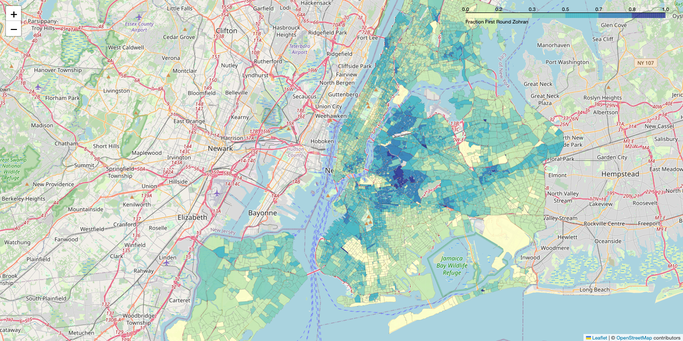

In [10]:
merged = df.to_crs(epsg=4326)  # convert to lat/lon
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)  # pick a suitable center

folium.Choropleth(
    geo_data=merged,
    data=merged,
    columns=["ElectDist", "ZohranFirstRoundFrac"],
    key_on="feature.properties.ElectDist",
    fill_color="YlGnBu",
    legend_name="Fraction First Round Zohran",
    line_opacity=0.1,
    fill_opacity=0.9,
).add_to(m)
png_bytes = m._to_png(5)
img = Image.open(BytesIO(png_bytes))
width, height = img.size
img_lowres = img.resize((width // 2, height // 2), Image.Resampling.LANCZOS)
display(img_lowres)

Pretty expected. Super great results in queens / astoria, good support downtown and uptown manhattan, somewhat lacking in deep south brooklyn, upper east/west side, staten island, north bronx.
